In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import toimage
from tensorflow.keras.datasets import mnist

In [0]:
from tensorflow.keras.utils import to_categorical

In [3]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(Y_train, 10)
y_test = to_categorical(Y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
import cv2

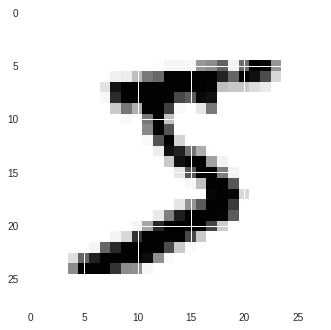

In [5]:
plt.imshow(X_train[0])

In [0]:
img = cv2.resize(X_train[0], (28,28))

In [0]:
def affine_image(img, x, y, angle, scale=1.0):
  w = 28
  h = 28

  center = (w/2, h/2)
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

  # 平行移動して(x, y)の位置に置く
  affine_matrix = rotation_matrix.copy()
  affine_matrix[0][2] = affine_matrix[0][2] - w/2 + x
  affine_matrix[1][2] = affine_matrix[1][2] - h/2 + y

  img_rot = cv2.warpAffine(img, affine_matrix, (w, h), flags=cv2.INTER_CUBIC)

  return img_rot

In [0]:
img_rot = affine_image(img, 8, 8, 0, 0.8)

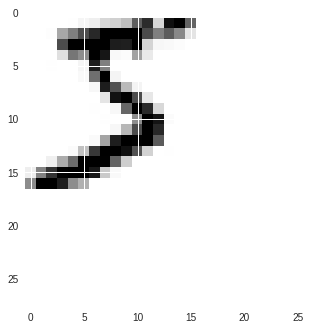

In [33]:
plt.imshow(img_rot)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam

In [0]:
model = Sequential()

model.add(Conv2D(100, 3, padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(200, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(200))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])


In [201]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.121.243.10:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8838957305458532334)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2530041724264914035)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6630727728733918605)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13456143427456486380)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14699039102163209343)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
tpu_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])


In [81]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=y_train,
    batch_size=1000, epochs=5,
    validation_data=(x_test.reshape(10000, 28, 28, 1), y_test)
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0143 - categorical_accuracy: 0.9955 - val_loss: 0.0303 - val_categorical_accuracy: 0.9910
Epoch 2/5
60000/60000 [==============================] - 5s 87us/step - loss: 0.0120 - categorical_accuracy: 0.9960 - val_loss: 0.0257 - val_categorical_accuracy: 0.9926
Epoch 3/5
60000/60000 [==============================] - 5s 87us/step - loss: 0.0120 - categorical_accuracy: 0.9958 - val_loss: 0.0251 - val_categorical_accuracy: 0.9936
Epoch 4/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0113 - categorical_accuracy: 0.9962 - val_loss: 0.0308 - val_categorical_accuracy: 0.9923
Epoch 5/5
60000/60000 [==============================] - 5s 85us/step - loss: 0.0110 - categorical_accuracy: 0.9965 - val_loss: 0.0355 - val_categorical_accuracy: 0.9912


In [82]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
def test_mnist_cnn(x_test, y_test):
    test_num = 10
    start = np.random.randint(x_test.shape[0] - test_num)
    x = x_test[start:start+test_num]
    y = y_test[start:start+test_num]

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])

    print(np.argmax(y, axis=1))

    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))

[4 7 4 2 7 4 9 1 0 6]
[4 7 4 2 7 4 9 1 0 6]


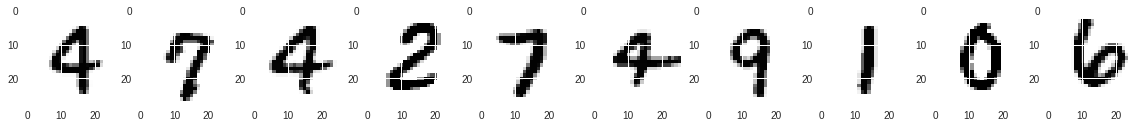

In [158]:
test_mnist_cnn(x_test, y_test)

In [0]:
import math
def test2_mnist_cnn(scale=0.5):
    size = 28
    test_num = 10
    x  = np.zeros((test_num, size, size), dtype = 'float32')
    start = np.random.randint(x_test.shape[0] - test_num)
    x_orig = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size - size*scale)
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
      #x[i] = affine_image(x_orig[i], x0, y0, 0, scale)
      x[i] = affine_image(x_orig[i], 10, 10, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])

    print(np.argmax(y, axis=1))

    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))

[6 6 3 4 4 2 8 1 0 6]
[9 9 9 1 1 9 9 6 9 9]


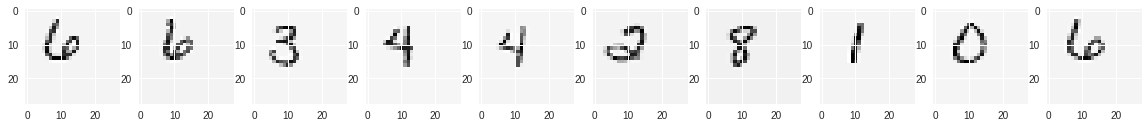

In [156]:
test2_mnist_cnn(0.6)

In [0]:
def test3_mnist_cnn(scale=0.8):
    size = 28
    test_num = 10
    x  = np.zeros((test_num, size, size), dtype = 'float32')
    start = np.random.randint(x_test.shape[0] - test_num)
    x_orig = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size - size*scale)
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
      x[i] = affine_image(x_orig[i], x0, y0, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        subplts[i].imshow(x[i])


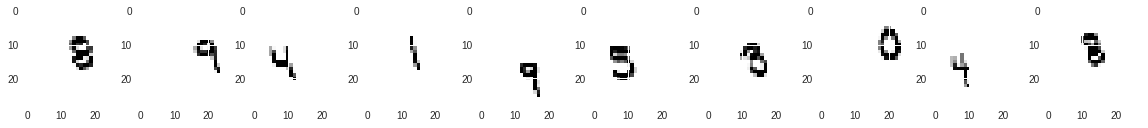

In [153]:
test3_mnist_cnn(0.5)

In [0]:
def make_train_mnist(X_orig):
  size = 28
  num = X_orig.shape[0]
  affined_x = np.zeros((num, size, size), dtype = 'float32')
  for i in range(num):
    scale = 1.0 - np.random.rand()*0.6 # scale = 0.0 ... 0.6
    padding_size = math.floor(size - size*scale)
    if padding_size >= 1:
      x0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2) 
      y0 = np.random.randint(padding_size) - math.floor(padding_size/2) + math.floor(size/2)
    else:
      x0 = math.floor(size/2) 
      y0 = math.floor(size/2) 
    affined_x[i] = affine_image(X_orig[i], x0, y0, 0, scale)
  return affined_x

In [0]:
affined_x_train = make_train_mnist(x_train)
affined_x_test = make_train_mnist(x_test)

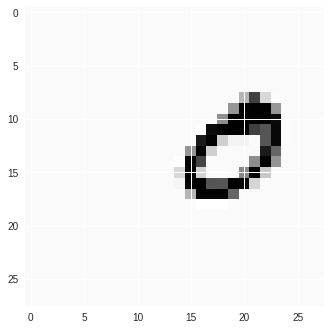

In [143]:
plt.imshow(affined_x_train[119])

In [211]:
affined_x_train = make_train_mnist(x_train)
affined_x_test = make_train_mnist(x_test)

tpu_model.fit(
    x=affined_x_train.reshape(60000, 28, 28, 1), y=y_train,
    batch_size=1000, epochs=2,
    validation_data=(affined_x_test.reshape(10000, 28, 28, 1), y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 117us/step - loss: 0.0714 - categorical_accuracy: 0.9825 - val_loss: 5.5711 - val_categorical_accuracy: 0.6159
Epoch 2/2
60000/60000 [==============================] - 7s 113us/step - loss: 0.0529 - categorical_accuracy: 0.9859 - val_loss: 1.8604 - val_categorical_accuracy: 0.8472


In [212]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


[3 9 3 3 5 5 0 7 9 5]
[3 9 3 3 5 5 0 7 0 8]


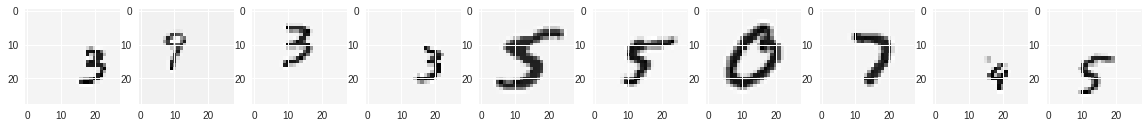

In [219]:
test_mnist_cnn(affined_x_test, y_test)